<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Binary_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data to train

In [1]:
!nvidia-smi

Thu Nov  5 18:11:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone --depth 1 https://github.com/Vengadore/Segmentation_OPTOS.git

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 1), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [1]:
# Download dataset
from IPython.display import clear_output
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1"
!sudo chmod 777 "EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1"
!mv "EQpZEnFP4WpKqChHB2BdlZQBzgcOKgcPpbtiKfzaSYz-Gg?download=1" "PDR.zip"
!unzip PDR.zip
!rm PDR.zip
clear_output(wait=False)

print("Data downloaded")

Data downloaded


In [2]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!pip install efficientnet_pytorch

In [1]:
from Segmentation_OPTOS.Tools.Annotations.Formats import VOC_format_V2
from Segmentation_OPTOS.Tools.Generators.BoundingB import createBackgroundBB
import os
import cv2
import numpy as np

In [2]:
path = "./"
dirs = os.listdir(path)
# Annotations
path_ann = os.path.join(path,"Annotations")
# ImageSets
path_sets = os.path.join(path,"ImageSets/")
# Images
path_imgs = os.path.join(path,dirs[2])

In [3]:
#Training set
with open(os.path.join(path_sets,'train.txt'),'r') as f:
    train = f.read().split('\n')[:-1]
#Validation set
with open(os.path.join(path_sets,'trainval.txt'),'r') as f:
    val = f.read().split('\n')[:-1]

In [4]:
train_ann = [os.path.join(path_ann,Ann+'.xml') for Ann in train]#[os.path.join(path_ann,Ann) for Ann in os.listdir(path_ann)]
val_ann = [os.path.join(path_ann,Ann+'.xml') for Ann in val]

In [5]:
from Segmentation_OPTOS.Tools.Annotations.view import show_annotations

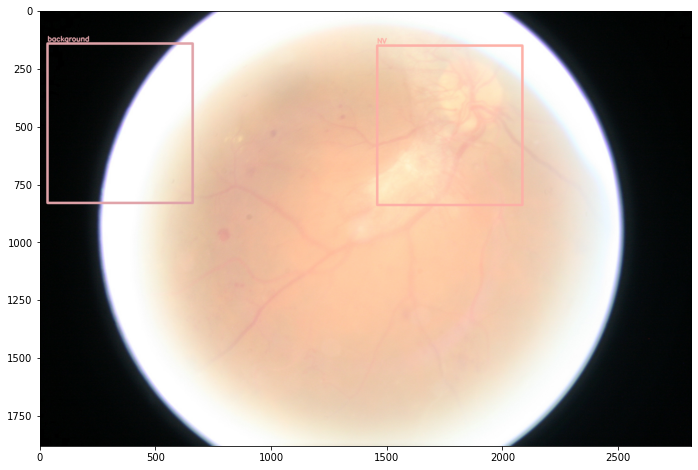

In [6]:
Ann = VOC_format_V2(train_ann[0])
createBackgroundBB(Ann)
show_annotations(Ann,"./train/")

## Set model and training parameters

In [7]:
from model import *

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = binary_model(number_classes=1)
Model.to(device);

Loaded pretrained weights for efficientnet-b7


In [10]:
import torch
import torch.optim as optim
from PIL import Image
from torchvision.transforms import Compose,Normalize,RandomHorizontalFlip
from torchvision.transforms import RandomRotation,RandomVerticalFlip,ToTensor,Resize

torch.manual_seed(17)


transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),RandomRotation(60)])
normalization = Compose([ToTensor(),
                         Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

criterion = nn.BCELoss()
optimizer = optim.Adam(Model.parameters(), lr=0.000005)

In [11]:
total_ann = sum([len(Ann.objects) for an in train_ann])
total_ann

336

In [ ]:
from tqdm import tqdm
import random
def get_box(obj):
    return (int(obj.find('xmin').text),int(obj.find('ymin').text),int(obj.find('xmax').text),int(obj.find('ymax').text))

epochs = 100
classes = {'NV':[1],'background':[0]}
patches_shape = (412,412)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    pbar = tqdm(sorted(iter(train_ann), key=lambda k: random.random()),ncols = 100,)
    running_loss = 0.0
    running_acc = 0.0
    t = 0
    for step in pbar:
        # Load data
        Ann = VOC_format_V2(step)
        img = Image.open(os.path.join("./train",Ann.get_attribute('filename')))
        
        #According to the number of objects (Vessels) create background boxes
        for i in range(len(Ann.objects)):
            createBackgroundBB(Ann)
        # Extract patch
        x_batch = torch.FloatTensor().to(device)
        y_batch = torch.FloatTensor().to(device)
        for i,patch in enumerate(sorted(iter(Ann.objects), key=lambda k: random.random())):
            if i>4:
                break
            P = img.crop(get_box(patch.find('bndbox'))).resize(patches_shape)
            P = transforms(P)
            P = normalization(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))
            name = patch.find('name').text
            y_batch = torch.cat((y_batch,torch.FloatTensor(classes[name]).unsqueeze(0).to(device)))
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = Model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += y_batch.shape[0]
        running_acc += torch.sum(y_batch.gt(0.5) == outputs.gt(0.5)).cpu().detach().numpy()
        acc = torch.sum(y_batch.gt(0.5) == outputs.gt(0.5)).cpu().detach().numpy()/y_batch.shape[0];
        pbar.set_description("Accuracy: {:0.5f} Loss: {:0.5f} ".format(running_acc/t,running_loss/t))
    #Validation
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for Ann_v in val_ann:
        with torch.no_grad():
            Ann = VOC_format_V2(Ann_v)
            img = Image.open(os.path.join("./valid",Ann.get_attribute('filename')))
            for i in range(len(Ann.objects)):
                createBackgroundBB(Ann)
            # Extract patch
            x_batch = torch.FloatTensor().to(device)
            y_batch = torch.FloatTensor().to(device)
            
            for i,patch in enumerate(sorted(iter(Ann.objects), key=lambda k: random.random())):
                if i>4:
                    break
            P = img.crop(get_box(patch.find('bndbox'))).resize(patches_shape)
            P = normalization(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))
            name = patch.find('name').text
            y_batch = torch.cat((y_batch,torch.FloatTensor(classes[name]).unsqueeze(0).to(device)))
            
            outputs = Model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            t += y_batch.shape[0]

            val_acc += torch.sum(y_batch.gt(0.5) == outputs.gt(0.5)).cpu().detach().numpy()
    print("Accuracy: {:0.5f} Loss: {:0.5f} ".format(val_acc/t,val_loss/t))

        
        


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Epoch 1


Accuracy: 0.66897 Loss: 0.25402 :  33%|█████████▏                  | 55/168 [00:36<01:12,  1.56it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.67111 Loss: 0.24169 :  49%|█████████████▋              | 82/168 [00:55<00:56,  1.54it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.69512 Loss: 0.24120 :  54%|███████████████             | 90/168 [01:00<00:50,  1.56it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.53488 Loss: 0.68785 
Epoch 2


Accuracy: 0.84416 Loss: 0.18611 :  15%|████▏                       | 25/168 [00:18<01:35,  1.50it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.85348 Loss: 0.19112 :  58%|████████████████▎           | 98/168 [01:08<00:50,  1.39it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.55814 Loss: 0.68214 
Epoch 3


Accuracy: 0.83333 Loss: 0.15454 :  12%|███▌                        | 21/168 [00:14<01:36,  1.52it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.80460 Loss: 0.17777 :  19%|█████▎                      | 32/168 [00:22<01:20,  1.69it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.81053 Loss: 0.17422 :  21%|█████▊                      | 35/168 [00:24<01:28,  1.51it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.69767 Loss: 0.67628 
Epoch 4


Accuracy: 0.78571 Loss: 0.17263 :   5%|█▌                           | 9/168 [00:06<01:42,  1.55it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.89778 Loss: 0.09525 :  48%|█████████████▌              | 81/168 [00:55<00:54,  1.59it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.88350 Loss: 0.10285 :  67%|██████████████████▏        | 113/168 [01:16<00:32,  1.71it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.89694 Loss: 0.09912 :  79%|█████████████████████▏     | 132/168 [01:29<00:22,  1.58it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.81395 Loss: 0.65585 
Epoch 5


Accuracy: 0.91892 Loss: 0.10840 :   9%|██▌                         | 15/168 [00:09<01:28,  1.74it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.88083 Loss: 0.08714 :  40%|███████████▎                | 68/168 [00:47<01:09,  1.44it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.88318 Loss: 0.08813 :  46%|████████████▊               | 77/168 [00:52<00:58,  1.56it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.89588 Loss: 0.08112 :  89%|████████████████████████   | 150/168 [01:42<00:11,  1.54it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.76744 Loss: 0.65456 
Epoch 6


Accuracy: 0.95307 Loss: 0.05300 :  58%|████████████████▏           | 97/168 [01:08<00:44,  1.60it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.95568 Loss: 0.05782 :  76%|████████████████████▌      | 128/168 [01:29<00:30,  1.32it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.65116 Loss: 0.67190 
Epoch 7


Accuracy: 0.93627 Loss: 0.05160 :  45%|████████████▋               | 76/168 [00:51<00:59,  1.54it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.93574 Loss: 0.05133 :  54%|███████████████▏            | 91/168 [01:02<01:01,  1.26it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.93561 Loss: 0.05086 :  57%|███████████████▊            | 95/168 [01:06<01:01,  1.18it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.67442 Loss: 0.66024 
Epoch 8


Accuracy: 0.96471 Loss: 0.03505 :  37%|██████████▎                 | 62/168 [00:42<01:05,  1.62it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.95185 Loss: 0.03919 :  61%|████████████████▍          | 102/168 [01:08<00:38,  1.71it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.94693 Loss: 0.04290 :  80%|█████████████████████▋     | 135/168 [01:30<00:20,  1.62it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.81395 Loss: 0.63853 
Epoch 9


Accuracy: 0.89552 Loss: 0.10609 :  14%|███▊                        | 23/168 [00:16<01:24,  1.72it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.93714 Loss: 0.06228 :  75%|████████████████████▎      | 126/168 [01:27<00:27,  1.55it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.86047 Loss: 0.63063 
Epoch 10


Accuracy: 0.96154 Loss: 0.03709 :  12%|███▎                        | 20/168 [00:13<01:45,  1.40it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.95796 Loss: 0.03138 :  74%|███████████████████▉       | 124/168 [01:23<00:35,  1.23it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.95735 Loss: 0.03353 :  92%|████████████████████████▊  | 154/168 [01:45<00:08,  1.66it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.74419 Loss: 0.64462 
Epoch 11
After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.97753 Loss: 0.02289 :  17%|████▊                       | 29/168 [00:21<01:47,  1.29it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.97758 Loss: 0.02498 :  49%|█████████████▊              | 83/168 [00:57<00:52,  1.62it/s]

After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.79070 Loss: 0.64503 
Epoch 12


Accuracy: 0.96721 Loss: 0.03237 :  40%|███████████▎                | 68/168 [00:46<01:07,  1.48it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


Accuracy: 0.96639 Loss: 0.02888 :  80%|█████████████████████▋     | 135/168 [01:31<00:19,  1.65it/s]

After 100 tries no Background Bounding Box was created
After 100 tries no Background Bounding Box was created


  0%|                                                                       | 0/168 [00:00<?, ?it/s]

Accuracy: 0.72093 Loss: 0.65417 
Epoch 13


Accuracy: 0.91026 Loss: 0.07663 :  18%|█████                       | 30/168 [00:20<01:46,  1.30it/s]

After 100 tries no Background Bounding Box was created


Accuracy: 0.95035 Loss: 0.04795 :  32%|████████▊                   | 53/168 [00:36<01:22,  1.39it/s]

In [ ]:
torch.save(Model,'Patches.ph')

In [ ]:
y_batch.shape[0]+2

4

In [ ]:
next(iter(train_ann))

In [ ]:
I = x_batch[1].cpu().detach().permute(1,2,0).numpy()
import matplotlib.pyplot as plt
plt.imshow(I)